# Import important libraries and frameworks

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,Conv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,Input,MaxPooling2D,Flatten
from tensorflow.keras.layers import UpSampling2D,Reshape,BatchNormalization,LeakyReLU, Conv2DTranspose,PReLU,ELU
from tensorflow.keras.optimizers import Adam
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

# check GPU availibility

In [1]:
from tensorflow.python.client import device_lib
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(device_lib.list_local_devices())
print("In you system GPU is enable: ",tf.test.is_built_with_cuda())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 727070438991667599
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8972118924141001616
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


NameError: name 'tf' is not defined

# Load Dataset

In [3]:
def mat2gray(img):
    A = np.double(img)
    out = np.zeros(A.shape, np.double)
    # MIN_MAX Normalization
    normalized = cv2.normalize(A, out, 1.0, 0.0, cv2.NORM_MINMAX)
    return out
# ADDED GAUSSIAN RANDOM NOISE FOR AGUMENTATION
def random_noise(image, mode='gaussian', seed=None, clip=True, **kwargs):
    image=img_to_array(image)
    image = mat2gray(image)
    mode = mode.lower()
    if image.min() < 0:
        low_clip = -1
    else:
        low_clip = 0
    if seed is not None:
        np.random.seed(seed=seed)
    if mode == 'gaussian':
        noise = np.random.normal(kwargs['mean'], kwargs['var'] ** 0.5,image.shape)        
        out = image  + noise
    if clip:        
        out = np.clip(out, low_clip, 1.0)
    return out

# def add_noise(img):
#     '''Add random noise to an image'''

#     deviation = 100*random.random()
#     noise = np.random.normal(0, deviation, img.shape)
#     img += noise
    
    
#     np.clip(img, 0., 255.)
#     return img

# input_generator=ImageDataGenerator(
#     preprocessing_function=add_noise,
#     dtype='float16',
#     rescale=1./255,
# )

# input_dataset=input_generator.flow_from_directory(
#     directory="C:\\Users\\Admin\\Desktop\\Video-Quality-Enhancement-using-Optical-Flow\\Davis\\DAVIS\\JPEGImages\\Full-Resolution",
#     target_size=(1080,1920),
#     class_mode=None,
#     batch_size=30,
#     shuffle=False
# )

# output_generator=ImageDataGenerator(
#     rescale=1./255,
#     dtype='float16'
# )
# output_dataset=output_generator.flow_from_directory(
#     directory="C:\\Users\\Admin\\Desktop\\Video-Quality-Enhancement-using-Optical-Flow\\Davis\\DAVIS\\JPEGImages\\Full-Resolution",
#     target_size=(1080,1920),
#     class_mode=None,
#     batch_size=30,
#     shuffle=False
# )

# x=input_dataset.next()
# for i in range(0,4):
#     image=x[i]
#     print(image.shape)
#     plt.imshow(image)
#     plt.show()
    
# x=output_dataset.next()
# for i in range(0,4):
#     image=x[i]
#     print(image.shape)
#     plt.imshow(image)
#     plt.show()


(256, 256, 3)


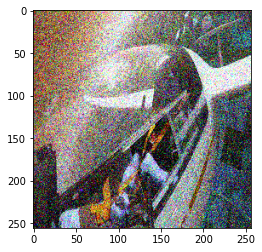

In [4]:
input_image_data=[]
output_image_data=[]
i=0
image_folder=r"C:\Users\luhar\Downloads\DAVIS\JPEGImages\480p"
#image_folder="C:\\Users\\Admin\\Desktop\\Video-Quality-Enhancement-using-Optical-Flow\\Davis\\DAVIS\\JPEGImages\\Full-Resolution"
for folder in os.listdir(image_folder):
    if i==10:
        break
    for file in os.listdir(os.path.join(image_folder,folder)):
        image_path=os.path.join(image_folder,folder,file)
        image=cv2.imread(image_path)
        image=cv2.resize(image,(256,256))
        image=np.array(image)
        image=image/255
        image = image.astype('float16')
        output_image_data.append(image)
        image=random_noise(image,'gaussian', mean=0,var=0.05)
        input_image_data.append(image)
    i+=1

shape_pic=input_image_data[0].shape

print(shape_pic)

for i in range(1):
    plt.imshow(input_image_data[i])
    plt.show()

In [5]:
with tf.device('/GPU:0'):
    X_train, X_test, y_train, y_test=train_test_split(input_image_data,output_image_data,test_size=0.20,random_state=42,)
    X_train=tf.convert_to_tensor(X_train,dtype=tf.float16)
    X_test=tf.convert_to_tensor(X_test,dtype=tf.float16)
    y_train=tf.convert_to_tensor(y_train,dtype=tf.float16)
    y_test=tf.convert_to_tensor(y_test,dtype=tf.float16)

In [6]:
del(input_image_data)
del(output_image_data)

In [7]:
def autoencoder(height, width, channel):
    shape=(height,width,channel)
    filters=(32,64)
    bottleneck=32
    channel_Dim=-1
    ##############################################################################
    inputs=Input(shape=shape)
    encoder=inputs
    for f in filters:
        encoder = Conv2D(f, (3, 3), strides=2, padding="same")(encoder)
        encoder = LeakyReLU(alpha=0.4)(encoder)
        encoder = BatchNormalization(axis=channel_Dim)(encoder)
    
    volumeSize = k.int_shape(encoder)
    encoder = Flatten()(encoder)
    encoder=Dense(128)(encoder)
    latent = Dense(bottleneck)(encoder)
    # build the encoder model
    encoder = Model(inputs, latent, name="encoder")

    latentInputs = Input(shape=(bottleneck))
    decoder=Dense(128)(latentInputs)
    decoder = Dense(np.prod(volumeSize[1:]))(decoder)
    decoder = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(decoder)
    # loop over our number of filters again, but this time in
    # reverse order
    for f in filters[::-1]:
    # apply a CONV_TRANSPOSE => RELU => BN operation
        decoder = Conv2DTranspose(f, (3, 3), strides=2,padding="same")(decoder)
        decoder = LeakyReLU(0.4)(decoder)
        decoder = BatchNormalization(axis=channel_Dim)(decoder)
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    decoder = Conv2DTranspose(shape[-1], (3, 3), padding="same")(decoder)
    outputs = Activation("sigmoid")(decoder)
    # build the decoder model
    decoder = Model(latentInputs, outputs, name="decoder")
    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")
    # return a 3-tuple of the encoder, decoder, and autoencoder
#########################################################################
    return autoencoder,encoder,decoder
   
with tf.device('/GPU:0'):
    
    autoencoder,encoder,decoder=autoencoder(256,256,3)
    optimizer=Adam(learning_rate=0.001,)
    autoencoder.compile(optimizer=optimizer,loss='mse',metrics=['accuracy'])

    print(encoder.summary())
    print(decoder.summary())
    autoencoder.fit(X_train,y_train,batch_size=8,epochs=50,validation_split=0.25,shuffle=True,)
    #autoencoder.fit(X_train,y_train,epochs=200,shuffle=True)
    

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256 

Epoch 33/50
57/57 [==============================] - 6s 114ms/step - loss: 0.0082 - accuracy: 0.6718 - val_loss: 0.0127 - val_accuracy: 0.6656
Epoch 34/50
57/57 [==============================] - 7s 114ms/step - loss: 0.0080 - accuracy: 0.6708 - val_loss: 0.0123 - val_accuracy: 0.6885
Epoch 35/50
57/57 [==============================] - 7s 114ms/step - loss: 0.0077 - accuracy: 0.6850 - val_loss: 0.0122 - val_accuracy: 0.6835
Epoch 36/50
57/57 [==============================] - 6s 114ms/step - loss: 0.0077 - accuracy: 0.6846 - val_loss: 0.0123 - val_accuracy: 0.6807
Epoch 37/50
57/57 [==============================] - 7s 114ms/step - loss: 0.0073 - accuracy: 0.6890 - val_loss: 0.0122 - val_accuracy: 0.6836
Epoch 38/50
57/57 [==============================] - 6s 114ms/step - loss: 0.0074 - accuracy: 0.6903 - val_loss: 0.0129 - val_accuracy: 0.6823
Epoch 39/50
57/57 [==============================] - 6s 114ms/step - loss: 0.0073 - accuracy: 0.6887 - val_loss: 0.0124 - val_accuracy: 0.6916

In [8]:
autoencoder.save('model')

INFO:tensorflow:Assets written to: model\assets


In [11]:
y_pred=autoencoder.predict(X_test,batch_size=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


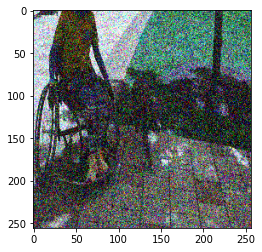

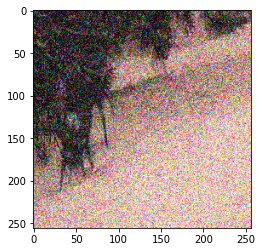

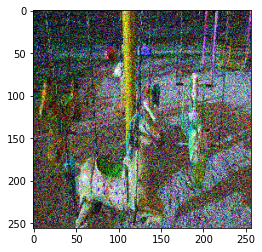

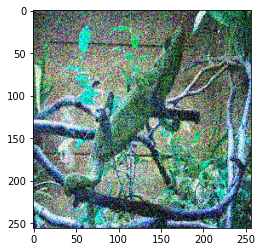

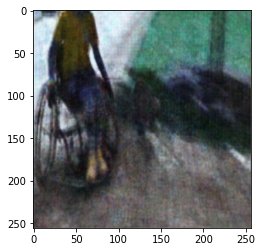

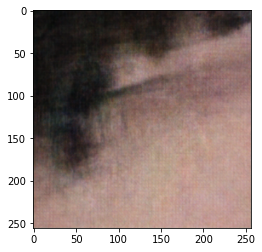

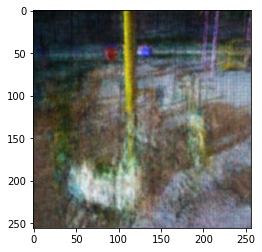

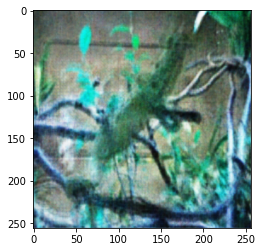

In [22]:
for i in range(4):
    plt.imshow(img_to_array(X_test[i]))
    plt.show()
for i in range(4):
    plt.imshow(img_to_array(y_pred[i]))
    plt.show()